In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from scipy import integrate

In [2]:
# 数据读取
file_name1 = "BAOData.txt"
dataB=np.loadtxt(file_name1, skiprows=1, usecols = (1,2,3), dtype=np.float32)
file_name2 = "SNIaData.txt"
dataS=np.loadtxt(file_name2, skiprows=0, usecols = (4,6,7), dtype=np.float32)
file_name3 = "ChronometersData.txt"
dataH=np.loadtxt(file_name3, skiprows=0, usecols = (0,1,2), dtype=np.float32)

In [3]:
# 将数据放入变量
xS=dataS[:,0]
xB=dataB[:,0]
xH=dataH[:,0]
yS=dataS[:,1]
yB=dataB[:,1]
yH=dataH[:,1]
yerrS=dataS[:,2]
yerrB=dataB[:,2]
yerrH=dataH[:,2]

# DESI数据
z_DV = np.array([0.30, 1.49])  # D_V的红移
z_DM = np.array([0.51, 0.71, 0.93, 1.32, 1.49, 2.33])  # D_M的红移
z_DH = np.array([0.51, 0.71, 0.93, 1.32, 2.33])  # D_H的红移

# 观测值
D_V_obs = np.array([7.93, 26.07])  # D_V
D_M_obs = np.array([13.62, 16.85, 21.71, 27.79, 26.07, 39.71])  # D_M
D_H_obs = np.array([20.98, 20.08, 17.88, 13.82, 8.52])  # D_H

# 误差（标准差）
sigma_DV = np.array([0.15, 0.67])  # D_V的误差
sigma_DM = np.array([0.25, 0.32, 0.28, 0.69, 0.67, 0.94])  # D_M的误差
sigma_DH = np.array([0.61, 0.60, 0.35, 0.42, 0.17])  # D_H的误差

# SDSS 数据
# D_V 数据
z_DV_SDSS = np.array([0.106, 0.15])  # D_V的红移
D_V_obs_SDSS = np.array([2.98, 4.51])  # D_V的观测值
sigma_DV_SDSS = np.array([0.13, 0.14])  # D_V的误差

# D_M 数据
z_DM_SDSS = np.array([0.38, 0.51, 0.70, 0.85, 1.48, 2.33, 2.33])  # D_M的红移
D_M_obs_SDSS = np.array([10.27, 13.38, 17.65, 19.50, 30.21, 37.60, 37.30])  # D_M的观测值
sigma_DM_SDSS = np.array([0.15, 0.18, 0.30, 1.00, 0.79, 1.90, 1.70])  # D_M的误差

# D_H 数据
z_DH_SDSS = np.array([0.38, 0.51, 0.70, 0.85, 1.48, 2.33, 2.33])  # D_H的红移
D_H_obs_SDSS = np.array([24.89, 22.43, 19.78, 19.60, 13.23, 8.93, 9.08])  # D_H的观测值
sigma_DH_SDSS = np.array([0.58, 0.48, 0.46, 2.10, 0.47, 0.28, 0.34])  # D_H的误差

In [4]:
# 常数
c_light=3e5

In [5]:
# 定义哈勃参数 H(z)
def H(z, theta):
    H0, c, a, m, wde, Mb, r_d = theta
    return H0*(1+z)**((3*(1+a)*(m-c**2*(wde+2*wde*a)))/(m*(2+3*a)))

def InvEz(z, theta):
    H0, c, a, m, wde, Mb, r_d = theta
    return H0/H(z, theta)

def InteEz(z, theta):
    Inte = []
    for zi in z:
        if zi > 0:
            # 直接使用quad进行快速积分
            fArea, _ = integrate.quad(InvEz, 0, zi, args=(theta))
            Inte.append(fArea)
        else:
            Inte.append(0)
    return np.array(Inte)

# def InteEz(z, theta):
#     datadim = len(z)
#     steplength = 0.001
#     Inte = []
#     for i in range(datadim):
#         xe = float(z[i])
#         if xe >= 0:
#             # 生成 z 数组
#             zi = np.arange(0, xe + steplength, steplength)
#             # 计算 invE (即1/Ez)
#             invE = InvEz(zi, theta)
#             # 使用 simpson 进行积分，正确传递参数
#             fArea = integrate.simpson(invE, x=zi)
#             Inte.append(fArea)
#         else:
#             continue
#     return np.array(Inte)

def D_L(z,theta):
    H0, c, a, m, wde, Mb, r_d = theta
    d_z=(1+z)*c_light/H0*InteEz(z, theta)
    return d_z



# 定义距离尺度 D_M(z) 和 D_V(z)
def D_M(z, theta):
    H0, c, a, m, wde, Mb, r_d =theta
    return D_L(z,theta)/(1+z)/r_d

def D_V(z,theta):
    H0, c, a, m, wde, Mb, r_d =theta
    # 计算D_V(z) = (D_M^2 * z / H(z))^(1/3)
    D_m = D_M(z, theta)
    H_z = H(z, theta)
    return ((D_L(z,theta)/(1+z))**2 *c_light * z / H_z) ** (1/3) / r_d

def D_H(z, theta):
    H0, c, a, m, wde, Mb, r_d = theta
    # 计算D_H(z) = c / H(z)
    H_z = H(z, theta)
    return c_light / H_z / r_d



In [6]:
def log_likelihood(theta):
    H0, c, a, m, wde, Mb, r_d= theta

    # H(z) data
    H_z=H(xH,theta)
    sigma2H = yerrH ** 2
    xiH=(yH -H_z) ** 2 / sigma2H
    ChiH=np.sum(xiH)
    # # BAO data
    # D_A=D_L(xB,theta)/(1+xB)
    # modelB=100*1.6*180/np.pi/D_A
    # sigma2B = yerrB ** 2
    # xiB=(yB - modelB) ** 2 / sigma2B
    # ChiB=np.sum(xiB)
    # SNe data
    modelS=5*np.log10(D_L(xS,theta))+25+Mb
    sigma2S = yerrS ** 2
    xiS=(yS - modelS) ** 2 / sigma2S
    # yiS=(yS - modelS) ** 1 / sigma2S
    # ziS=1.0 / sigma2S
    XiS=np.sum(xiS)
    # YiS=np.sum(yiS)
    # ZiS=np.sum(ziS)
    # ChiS=XiS-YiS**2/ZiS+np.log10(ZiS/np.pi/2) 边缘化M_b

    # DESI
    # D_V的预测
    model_DV = D_V(z_DV, theta)
    chi2_DV = np.sum(((D_V_obs - model_DV) / sigma_DV) ** 2)
    # D_M的预测
    model_DM = D_M(z_DM, theta)
    chi2_DM = np.sum(((D_M_obs - model_DM) / sigma_DM) ** 2)
    # D_H的预测
    model_DH = D_H(z_DH, theta)
    chi2_DH = np.sum(((D_H_obs - model_DH) / sigma_DH) ** 2)
    # 总的Chi2
    ChiD=(chi2_DV + chi2_DM + chi2_DH)
    
    # BAO SDSS 6dF
    # D_V的预测
    model_DV_SDSS = D_V(z_DV_SDSS, theta)
    chi2_DV_SDSS = np.sum(((D_V_obs_SDSS - model_DV_SDSS) / sigma_DV_SDSS) ** 2)
    # D_M的预测
    model_DM_SDSS = D_M(z_DM_SDSS, theta)
    chi2_DM_SDSS = np.sum(((D_M_obs_SDSS - model_DM_SDSS) / sigma_DM_SDSS) ** 2)
    # D_H的预测
    model_DH_SDSS = D_H(z_DH_SDSS, theta)
    chi2_DH_SDSS = np.sum(((D_H_obs_SDSS - model_DH_SDSS) / sigma_DH_SDSS) ** 2)
    # 总的Chi2
    ChiD_SDSS=(chi2_DV_SDSS + chi2_DM_SDSS + chi2_DH_SDSS)
    return -ChiH-XiS-ChiD_SDSS-ChiD

# 先验函数
def log_prior(theta):
    H0, c, a, m, wde, Mb, r_d = theta
    if 50 < H0 < 100 and -1.5<wde<0 and -20<c<0 and ((3*(1+a)*(m-c**2*(wde+2*wde*a)))/(m*(2+3*a)))>=0 and -30<Mb<0 and 100<r_d<200 and -2<m<0 :  # 对H0进行限制
    # if 67 < H0 < 75 and  -1.1<wde<-0.9  and 24<mu<27:
        return 0.0
    return -np.inf

# 后验函数
def log_probability(theta):
    lp = log_prior(theta)
    # if np.isnan(log_likelihood(theta)):
    #     print("nan number is found",theta)
    #     return -np.inf
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

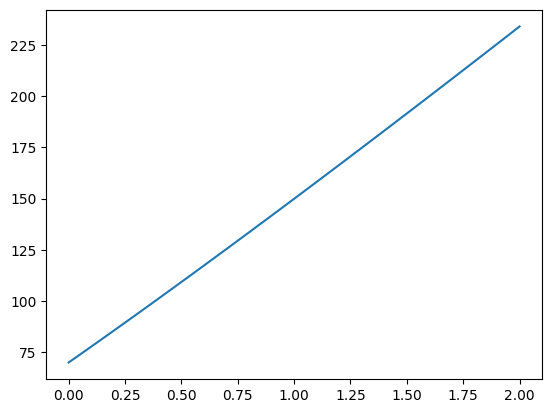

In [7]:
z = np.linspace(0, 2, 100,dtype=np.float32)
params=[70,-6,-1,-1.2,-1,-19,150]
params=[70, -6, -1.01, -1, -1, -19, 147]
plt.plot(z,H(z,params),label='a=1')
# params2=[70,-5,-1,-1,-0.8,-19,150]
# plt.plot(z,H(z,params2),label='a=0')
# plt.legend(fontsize=14)

In [8]:
print(log_likelihood(params))

-4501.633951727293


In [9]:
# 初始化参数
nwalkers = 70
ndim = 7
nstep=2000

initial_values = np.array([70, -6, -1.01, -1, -1,-19, 150])
std_devs = np.array([5, 1.0, 0.05, 0.05, 0.1, 0.05, 20])  # 对应每个参数的扰动大小
np.random.seed(42)  # 设置固定的随机种子

# 使用不同标准差生成扰动
p0 = initial_values + std_devs * np.random.randn(nwalkers, ndim)*1e-1

In [ ]:
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

import emcee
from multiprocessing import Pool
import time


with Pool() as pool:
    start = time.time()
    # 设置emcee采样
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,pool=pool)
    sampler.run_mcmc(p0, nstep, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

255 CPUs


  0%|          | 0/2000 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
 14%|█▍        | 284/2000 [02:34<15:36,  1.83it/s]/tmp/ipykernel_6974/1825236080.py:7: RuntimeWarning: overflow encountered in square
  xiH=(yH -H_z) ** 2 / sigma2H
 16%|█▌        | 321/2000 [02:53<14:00,  2.00it/s]/tmp/ipykernel_6974/1825236080.py:7: RuntimeWarning: overflow encountered in square
  xiH=(yH -H_z) ** 2 / sigma2H
 17%|█▋        | 336/2000 [03:01<15:03,  1.84it/s]/tmp/ipykernel_6974/1825236080.py:7: RuntimeWarning: overflow encountered in square
  xiH=(yH -H_z) ** 2 / sigma2H
 17%|█▋        | 343/2000 [03:05<14:46,  1.87it/s]/tmp/ipykernel_6974/1825236080.py:7: RuntimeWarning: overflow encountered in square
  xiH=(yH -H_z) ** 2 / sigma2H
 19%|█▉        | 389/2000 [03:28<13:50,  1.94it/s]/tmp/ipykernel_6974/1179675794.py:4: RuntimeWarning: overflow encountered in powe

In [ ]:
# 处理结果
samples = sampler.get_chain(discard=400, thin=100, flat=True)   
H0_median = np.median(samples[:, 0])
print(H0_median)
c_midian = np.median(samples[:, 1])
print(c_midian)
a_midian = np.median(samples[:, 2])
print(a_midian)
m_midian = np.median(samples[:, 3])
print(m_midian)
wde_midian = np.median(samples[:, 4])
print(wde_midian)
Mb_midian = np.median(samples[:, 5])
print(Mb_midian)
rd_midian = np.median(samples[:, 6])
print(rd_midian)

In [ ]:
rd_midian*H0_median/100

In [ ]:
np.savetxt("MC_chainWithDESI_fQT_D=0.txt", samples ,fmt='%f',delimiter=',')

In [ ]:
from getdist import plots, MCSamples
import getdist
%matplotlib inline
labels= ['H_0','c','a','1/m','w_{de}','M_b','r_d']
names = ['H_0','c','a','1/m','w_{de}','M_b','r_d']
samplesplot = MCSamples(samples=samples,names =names, labels = labels)
g = plots.get_subplot_plotter()
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 14
g.triangle_plot(samplesplot , filled=True, legend_labels=['BAO+SNIa+OHD', 'Simulation 2'], 
    legend_loc='upper right',title_limit=1)

labels= labels

In [ ]:
# import corner
# fig = corner.corner(samples, labels=labels)
# plt.show()

import corner

# 绘制一个定制的corner图
corner.corner(samples,
              labels=labels,
              fill=True,             # 填充颜色
              color='blue',          # 颜色
              levels=[0.68, 0.95],   # 显示68%、95%的置信区间
              show_titles=True,      # 显示标题
              title_kwargs={"fontsize": 12},
              label_kwargs={"fontsize": 14})
plt.plot()

In [ ]:
samples = sampler.get_chain()


fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
#samples = np.loadtxt(file_name, delimiter=',', skiprows=0, dtype=np.float32)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:,i], "k", color='black',alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [ ]:
# 处理结果
samples = sampler.get_chain(discard=200, thin=5, flat=True)
theta_median = [] 
for n in range(ndim):
    theta_median.append(np.mean(samples[:,n]))
print(theta_median)

In [ ]:
def H_LCDM(z, H0=68.52, Omega_m=0.295, Omega_Lambda=1-0.295, Omega_k=0.0):
    return H0 * np.sqrt(Omega_m * (1 + z)**3 + Omega_k * (1 + z)**2 + Omega_Lambda)

In [ ]:
def modelS(z ,theta):
    H0, c, a, m, wde, Mb, r_d = theta
    modelS=5*np.log10(D_L(z,theta))+25+Mb
    return modelS
    
x0 = np.linspace(0.01, 2, 100)
plt.errorbar(xS, yS, yerrS, fmt=".k", capsize=0)
plt.plot(x0, modelS(x0, theta_median), "k", label="fitting line",color='r')
plt.legend(fontsize=14)
plt.xlim(-.1, 2.0)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.show() 

In [ ]:
def modelH(z,theta):
    H0, c, a, m, wde, Mb, r_d = theta
    modelH=H(z,theta)
    return modelH  
    
x0 = np.linspace(0, 2.5, 100)
plt.errorbar(xH, yH, yerrH, fmt=".k", capsize=0, color='b')
plt.plot(x0, modelH(x0, theta_median), "k", label="Our model",color='r')
plt.plot(x0, H_LCDM(x0), "k", label=r'$\Lambda \text{CDM}$ ')
plt.legend(fontsize=14)
plt.legend(fontsize=14)
plt.xlim(0, 2.5)
plt.xlabel("z")
plt.ylabel("H(z)")
plt.show()

In [ ]:
def modelB(z, theta):
    H0, c, a, m, wde, Mb, r_d = theta
    D_A=D_L(z,theta)/(1+z)
    modelB=100*1.6*180/np.pi/D_A
    return modelB   
    
x0 = np.linspace(0.1, 2.5, 100)
plt.errorbar(xB, yB, yerrB, fmt=".k", capsize=0)
plt.plot(x0, modelB(x0, theta_median), "k", label="fitting line",color='r')
plt.legend(fontsize=14)
plt.xlim(0, 2.5)
plt.xlabel("x")
plt.ylabel("theta")
plt.show()

In [ ]:
def model_DV(z, theta):
    H0, c, a, m, wde, Mb, r_d = theta
    model_DV = D_V(z, theta)
    return model_DV

x0 = np.linspace(0.1, 2.5, 100)
plt.errorbar(z_DV, D_V_obs, sigma_DV, fmt=".", capsize=0, label='DESI')
plt.errorbar(z_DV_SDSS, D_V_obs_SDSS, sigma_DV_SDSS, fmt=".", capsize=0, label='6dFGS and SDSS')
plt.plot(x0, model_DV(x0, theta_median), "k", label="fitting line",color='r')
plt.legend(fontsize=14)
plt.xlim(0, 2.5)
plt.xlabel("z")
plt.ylabel("\theta")
plt.show()

In [ ]:
def model_DH(z, theta):
    H0, c, a, m, wde, Mb, r_d = theta
    model_DH = D_H(z, theta)
    return model_DH

x0 = np.linspace(0.1, 2.5, 100)
plt.errorbar(z_DH, D_H_obs, sigma_DH, fmt=".", capsize=0, label='DESI')
plt.errorbar(z_DH_SDSS, D_H_obs_SDSS, sigma_DH_SDSS, fmt=".", capsize=0, label='SDSS')
plt.plot(x0, model_DH(x0, theta_median), "k", label="fitting line",color='r')
plt.legend(fontsize=14)
plt.xlim(0, 2.5)
plt.xlabel("z")
plt.ylabel("D_H/r_d")
plt.show()

In [ ]:
def model_DM(z, theta):
    H0, c, a, m, wde, Mb, r_d = theta
    model_DM = D_M(z, theta)
    return model_DM

x0 = np.linspace(0.1, 2.5, 100)
plt.errorbar(z_DM, D_M_obs, sigma_DM, fmt=".", capsize=0,label='DESI')
plt.errorbar(z_DM_SDSS, D_M_obs_SDSS, sigma_DM_SDSS, fmt=".", capsize=0,label='SDSS')
plt.plot(x0, model_DM(x0, theta_median), "k", label="fitting line",color='r')
plt.legend(fontsize=14)
plt.xlim(0, 2.5)
plt.xlabel("z")
plt.ylabel("D_M/r_d")
plt.show()

In [ ]:
log_likelihood_max = log_likelihood(theta_median)
n = 4000
k = 2  # 模型的自由参数个数
# 计算 AIC 和 BIC
AIC = 2 * k - 2 * log_likelihood_max
BIC = k * np.log(n) - 2 * log_likelihood_max

print(f"AIC: {AIC:.2f}")
print(f"BIC: {BIC:.2f}")